Bible verse classifier
=========
-----

As a christian I was wondering if I could build a simple model that can classify a given verse to the right **Testament**.

I found the [website](http://bibledatabase.com/bibles.html) where csv files for bible verse can be downloaeded. I wanted to use New International Version(NIV) for the model <BR>since my church uses it. But it was not available from the website since its text is Copyrighted. I chose to use King James Version (KJV) instead.

(*I chose to build* ***Naive Bayes model*** *using machine learning platform* ***h2o***)

In [1]:
import pandas as pd
import numpy as np
import h2o

from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from collections import Counter

import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', -1)

We Define the file path and import the data into Pandas data frame.
---
The file downloaded from the website contains all the verses from King James Version bible.<BR>
There are five columns <BR>
* index number
* book number - All books from the bible are numbered in order ( Genesis = 1, Exodus = 2, etc )
* chapter number
* verse number
* actual text for verse

We name each column as **index**, **book**, **chapter**, **verse**, and **text**, respectively.

In [2]:
file_path = 'C:\\Users\\Young Wook\\Desktop\\stuffs\\DS\\projects\\bible\\b_kjv.txt'
df_all = pd.read_csv(file_path,header = None,names = ['index','book','chapter','verse','text'], sep = '\t')

Let's look at some of the data.
---
There are 31103 verses and 66 books in total.

In [3]:
df_all.head()

,index,book,chapter,verse,text
0,1,1,1,1,In the beginning God created the heaven and the earth.
1,2,1,1,2,"And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters."
2,3,1,1,3,"And God said, Let there be light: and there was light."
3,4,1,1,4,"And God saw the light, that it was good: and God divided the light from the darkness."
4,5,1,1,5,"And God called the light Day, and the darkness he called Night. And the evening and the morning were the first day."


In [4]:
#df_all.groupby(by='book').size()
#df_all.count()
df_all.tail()

,index,book,chapter,verse,text
31098,31099,66,22,17,"And the Spirit and the bride say, Come. And let him that heareth say, Come. And let him that is athirst come. And whosoever will, let him take the water of life freely."
31099,31100,66,22,18,"For I testify unto every man that heareth the words of the prophecy of this book, If any man shall add unto these things, God shall add unto him the plagues that are written in this book:"
31100,31101,66,22,19,"And if any man shall take away from the words of the book of this prophecy, God shall take away his part out of the book of life, and out of the holy city, and from the things which are written in this book."
31101,31102,66,22,20,"He which testifieth these things saith, Surely I come quickly. Amen. Even so, come, Lord Jesus."
31102,31103,66,22,21,The grace of our Lord Jesus Christ be with you all. Amen.


"Index" column makes this look confusing, so let's store a new data frame without it.
---

In [5]:
df = df_all.iloc[:,1:]
df.head()

,book,chapter,verse,text
0,1,1,1,In the beginning God created the heaven and the earth.
1,1,1,2,"And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters."
2,1,1,3,"And God said, Let there be light: and there was light."
3,1,1,4,"And God saw the light, that it was good: and God divided the light from the darkness."
4,1,1,5,"And God called the light Day, and the darkness he called Night. And the evening and the morning were the first day."


Let's create response column.
---
Bible consists of 66 books with 39 from the Old Testament and 27 from the New Testament.<BR>
We assign 0 to all the books from the Old Testament and 1 to the ones from the New Testament.<BR>
And create a new column, **'testament'**.

In [6]:
def testament_func(x):
    if x <= 39: return 0
    else: return 1

df['testament'] = df['book'].apply(testament_func)

Here is the distribution of verses by testaments.<BR>
The old testament has about three times more verses than the new testament.

In [7]:
df['verse'].groupby([df['testament']]).count()

testament
0    23145
1    7958 
dtype: int64

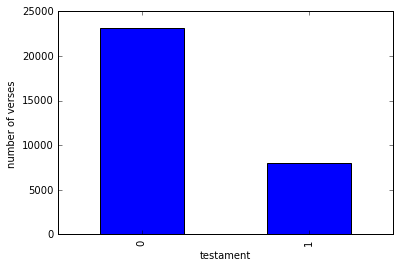

In [8]:
df['verse'].groupby([df['testament']]).count().plot(kind='bar')
plt.ylabel('number of verses')
plt.show()

Now, we need a vocabulary list
---
I selected the terms I thought were significant for each testaments, and created the list with those terms. Total number of terms is 100.

In [9]:
old_testament_terms = ['adam','eve','noah','david','joshua','samuel','elijah','isaiah','abraham','jacob','solomon'\
                       ,'jeremiah','baal','israel','hebrew','messiah','altar','egypt','philistine','sarah','pharaoh'\
                      ,'babylon','elisha','prophet','levi','offering','king','isaac','rachel','leah','esau','reuben'\
                      ,'simeon','dan','daniel','naphtali','gad','asher','issachar','zebulun','dinah','benjamin'\
                      ,'tamar','ruth','job','goliath','gideon','jephthah','samson','eli','jonah','hosea','tent'\
                      ,'tabernacle','ark','covenant','ezra','nehemiah','esther','ezekiel','zechariah','abram','sarai'\
                      ,'aaron','miriam','cloud','firstborn','staff','command']
new_testament_terms = ['jesus','pharisee','gentile','rome','paul','peter','john','mary','christ','cross','resurrect'\
                      ,'crucified','heaven','suffer','holy','prison','gospel','preach','apostle','teacher'\
                      ,'baptism','baptized','kingdom','parale','miracle','hosanna','sabbath','church','righteousness'\
                      ,'james','hallelujah']
vocab = old_testament_terms + new_testament_terms
print len(old_testament_terms),'+',len(new_testament_terms),'=',len(vocab)

69 + 31 = 100


We craete a document-term matrix for the verses.
---
Let's use a simple CountVectorizer with our vocabulary list <BR>
We import the matrix to pandas data frame and concatnate it with the response column.

In [10]:
count_vectorizer = CountVectorizer( vocabulary = vocab )
dtm = count_vectorizer.fit_transform(df.text).todense()

In [11]:
df_dtm = pd.DataFrame( data = dtm, columns = vocab )

In [12]:
df_final = pd.concat([df_dtm,df.testament], axis = 1)

We convert pandas data frame to python dictionary to h2o data frame.
---
First, let's initialize h2o.<BR>
Current version of h2o (3.8.1.3) doesn't support direct conversion from pandas data frame to h2o.<BR>

In [13]:
h2o.init()



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: c:\users\youngw~1\appdata\local\temp\tmpn8zi7j\h2o_Young_Wook_started_from_python.out
JVM stderr: c:\users\youngw~1\appdata\local\temp\tmptn2zkv\h2o_Young_Wook_started_from_python.err
Using ice_root: c:\users\youngw~1\appdata\local\temp\tmpu7mnad


Java Version: java version "1.7.0_79"
Java(TM) SE Runtime Environment (build 1.7.0_79-b15)
Java HotSpot(TM) 64-Bit Server VM (build 24.79-b02, mixed mode)


Starting H2O JVM and connecting: . Connection successful!


H2O cluster uptime:,2 seconds 281 milliseconds
H2O cluster version:,3.8.1.3
H2O cluster name:,H2O_started_from_python_Young_Wook_vpr492
H2O cluster total nodes:,1
H2O cluster total free memory:,1.74 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None


In [14]:
temp_dic = {}
for key in df_final.keys():
    temp_data = list(df_final[key].values)
    temp_dic.update({key:temp_data})
    
data_hex = h2o.H2OFrame(temp_dic)


Parse Progress: [##################################################] 100%


Change data type for response column to 'category' and check if it is changed properly.<BR>
-- 'asfactor' changes other data types to categorical type in h2o.<BR>
-- Proper type for the response should be 'enum'.

In [15]:
data_hex['testament'] = data_hex['testament'].asfactor()

In [16]:
data_hex['testament'].types

{'testament': 'enum'}

Store proper **features** and **response**.

In [17]:
features = data_hex.names
response = ('testament')
features.remove(response)

We split the data into train and test.
---
The verses are sorted in default so we need to shuffle first and split.

In [18]:
random_idx = data_hex[response].runif(seed = 1234)
train_hex = data_hex[ random_idx < 0.7 ]
test_hex = data_hex[ random_idx >= 0.7 ]

We build Naive Bayes model with train data.
---
Test data is used as a validation.

In [19]:
nb_model_1 = h2o.naive_bayes( x = features, y = response, training_frame = train_hex, validation_frame = test_hex )


naivebayes Model Build Progress: [##################################################] 100%


Finally, let's check the performance of the model on test set.
---

In [20]:
nb_model_1.model_performance( valid = True ).confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.999999411902: 


,0,1,Error,Rate
0,1419.0,5475.0,0.7942,(5475.0/6894.0)
1,149.0,2192.0,0.0636,(149.0/2341.0)
Total,1568.0,7667.0,0.609,(5624.0/9235.0)


In [21]:
nb_model_1.model_performance(valid = True).auc()

0.5687203998499522

Total error rate of 0.609 from the confusion matrix and AUC score of 0.569 look pretty bad.<BR>
For a better result, let's build a better vocabulary list. We will "stem" all the words in the verses and count the frequency to get the list.


We create another column for the text with stemmed words.
---
We first remove all the punctuations from the text, and then use SnowballStemmer to "stem" each word in all the verses.<BR>
We do this by defining a function and apply it to a new column, **'split_stemmed'**.<BR>
Also another column, **'stemmed'** is needed for a joined string of stemmed vocabularies.

In [22]:
stemmer = SnowballStemmer('english')
def stemmizer(text):
    table = string.maketrans("","")
    vocab_list = [ stemmer.stem(word) for word in (text.translate(table, string.punctuation)).split() ]
    return vocab_list
    
df['split_stemmed'] = df['text'].apply(stemmizer)

"stopwords" from nltk is used for removing stopwords.

In [23]:
stop = set(stopwords.words('english'))
df['split_stemmed'] = df['split_stemmed'].apply(lambda x: [x for x in x if x not in stop])
df['stemmed'] = df['split_stemmed'].apply(lambda x: ' '.join(x))

Let's take a look at the data with added columns.
---

In [24]:
df.head()

,book,chapter,verse,text,testament,split_stemmed,stemmed
0,1,1,1,In the beginning God created the heaven and the earth.,0,"[begin, god, creat, heaven, earth]",begin god creat heaven earth
1,1,1,2,"And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters.",0,"[earth, without, form, void, dark, upon, face, deep, spirit, god, move, upon, face, water]",earth without form void dark upon face deep spirit god move upon face water
2,1,1,3,"And God said, Let there be light: and there was light.",0,"[god, said, let, light, light]",god said let light light
3,1,1,4,"And God saw the light, that it was good: and God divided the light from the darkness.",0,"[god, saw, light, good, god, divid, light, dark]",god saw light good god divid light dark
4,1,1,5,"And God called the light Day, and the darkness he called Night. And the evening and the morning were the first day.",0,"[god, call, light, day, dark, call, night, even, morn, first, day]",god call light day dark call night even morn first day


Now, for a "better" vocabulary list,
---

Let's create two seperates lists with all the vocabularies for old and new testaments. We use counter to get the most common vocabularies lists.<BR>
Then, considering the distribution of the verses in the old and new testament, we remove some vocabularies.

In [25]:
old, new = [], []
for x in df[df.testament == 0].loc[:,'split_stemmed']: old += x
for x in df[df.testament == 1].loc[:,'split_stemmed']: new += x
count_old, count_new = Counter(old), Counter(new)
most_old, most_new = count_old.most_common(125), count_new.most_common(75)

In [26]:
old, new = [], []
for x in most_old:
    if x[0] not in [y[0] for y in most_new]: old.append(x[0])
    else:
        for i in most_new:
            if (x[0] == i[0]) and (x[1] > (i[1]*3)): old.append(x[0])

for x in most_new:
    if x[0] not in [y[0] for y in most_old]: new.append(x[0])
    else:
        for i in most_old:
            if (x[0] == i[0]) and ((x[1]*3) > i[1]): new.append(x[0])

vocab = old + new
print len(old),'+',len(new),'=',len(vocab)

96 + 45 = 141


We create dtm with the new vocabulary list and repeat the same procedure.
---

In [27]:
count_vectorizer = CountVectorizer( vocabulary = vocab )
dtm = count_vectorizer.fit_transform( df.stemmed ).todense()

In [28]:
df_dtm = pd.DataFrame( data = dtm, columns = vocab )

In [29]:
df_final = pd.concat([df_dtm,df.testament], axis = 1)

In [30]:
temp_dic = {}
for key in df_final.keys():
    temp_data = list(df_final[key].values)
    temp_dic.update({key:temp_data})
    
data_hex = h2o.H2OFrame(temp_dic)


Parse Progress: [##################################################] 100%


In [31]:
data_hex['testament'] = data_hex['testament'].asfactor()

In [32]:
data_hex['testament'].types

{'testament': 'enum'}

In [33]:
features = data_hex.names
response = ('testament')
features.remove(response)

In [34]:
random_idx = data_hex[response].runif(seed = 1234)
train_hex = data_hex[ random_idx < 0.7 ]
test_hex = data_hex[ random_idx >= 0.7 ]

In [35]:
nb_model_2 = h2o.naive_bayes( x = features, y = response, training_frame = train_hex, validation_frame = test_hex)


naivebayes Model Build Progress: [##################################################] 100%


In [36]:
nb_model_2.model_performance(valid = True).confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.874336773041: 


,0,1,Error,Rate
0,5294.0,1600.0,0.2321,(1600.0/6894.0)
1,758.0,1583.0,0.3238,(758.0/2341.0)
Total,6052.0,3183.0,0.2553,(2358.0/9235.0)


In [37]:
nb_model_2.model_performance(valid = True).auc()

0.7604350965688147

Total error rate of 0.255 from the confusion matrix and AUC score of 0.760 look much better than the previous ones.<BR>


Let's try another vocabulary list. This time, we use CountVectorizer with a built-in stopwords for English to create the new vocabulary list. <BR>
A maximum document frequency and a minimum document frequency are set up as 0.95 and 0.01, respectively.<BR>
Then, the same procedure is repeated.

In [38]:
count_vectorizer = CountVectorizer( stop_words = 'english', max_df = 0.95, min_df = 0.01 )
dtm = count_vectorizer.fit_transform( df.stemmed ).todense()
vocab = count_vectorizer.get_feature_names()

In [39]:
df_dtm = pd.DataFrame( data = dtm, columns = vocab )

In [40]:
df_final = pd.concat([df_dtm,df.testament], axis = 1)

In [41]:
temp_dic = {}
for key in df_final.keys():
    temp_data = list(df_final[key].values)
    temp_dic.update({key:temp_data})
    
data_hex = h2o.H2OFrame(temp_dic)


Parse Progress: [##################################################] 100%


In [42]:
data_hex['testament'] = data_hex['testament'].asfactor()

In [43]:
data_hex['testament'].types

{'testament': 'enum'}

In [44]:
features = data_hex.names
response = ('testament')
features.remove(response)

In [45]:
random_idx = data_hex[response].runif(seed = 1234)
train_hex = data_hex[ random_idx < 0.7 ]
test_hex = data_hex[ random_idx >= 0.7 ]

In [46]:
nb_model_3 = h2o.naive_bayes( x = features, y = response, training_frame = train_hex, validation_frame = test_hex )


naivebayes Model Build Progress: [##################################################] 100%


In [47]:
nb_model_3.model_performance( valid = True ).confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.999999855648: 


,0,1,Error,Rate
0,4828.0,2066.0,0.2997,(2066.0/6894.0)
1,576.0,1765.0,0.246,(576.0/2341.0)
Total,5404.0,3831.0,0.2861,(2642.0/9235.0)


In [48]:
nb_model_3.model_performance( valid = True ).auc()

0.7466501338942654

The second model actually performed slightly better. Therefor, in terms of AUC score, the second model is the "best" model out of the three.<BR>
Let's plot a ROC curve for the second model.<BR>
(The origin was missing from the set for some reason, so I had to manually add it) 

AUC score is 0.760435096569


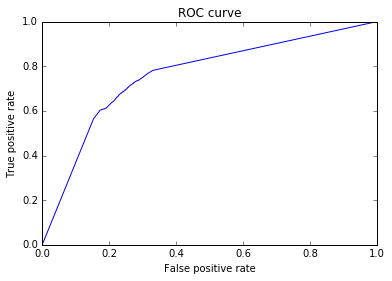

In [49]:
print 'AUC score is',nb_model_2.model_performance( valid = True ).auc()

roc = nb_model_2.roc()
tpr = [0.0] + roc[0]
fpr = [0.0] + roc[1]

plt.plot(tpr, fpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()